# **Save this file as 11828668_11304421_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. Hence as an example for 2 students:
12301230_3434343_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [9]:
NAME = "Qiao Ren"
NAME2 = "Kevin Waller"
EMAIL = "qiao.ren@student.uva.nl"
EMAIL2 = "kevin.waller@student.uva.nl"


# Lab 2: Classification

### Machine Learning 1, September/October 2020

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [10]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [11]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [12]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

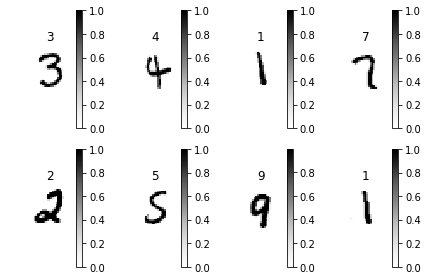

In [13]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&=1 - \frac{exp(log(q_j))}{Z}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&=-\frac{exp(log(q_j))}{Z}
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

$\frac{\partial \mathbf{\log q}}{\partial \mathbf{W}} = \frac{\partial}{\partial \mathbf{W}}[\mathbf{W}^{T}\mathbf{x} + \mathbf{b}] = \mathbf{x}^{T} \in \mathbb{R}^{1\times784}$

$\mathbf{\delta}^q \in \mathbb{R}^{10\times1}$

$\mathbf{\delta}^q\frac{\partial \mathbf{\log q}}{\partial \mathbf{W}} = \mathbf{\delta}^q \mathbf{x}^{T} \in \mathbb{R}^{10\times784}$

Note that there are still two cases due to $\mathbf{\delta}^q$ when $j=t^{n}$ and when $j\neq t^{n}$

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [14]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):

    logq = x.dot(w) + b

    Z = np.sum(np.exp(logq))

    logZ = np.max(logq) + np.log(np.sum(np.exp(logq - np.max(logq))))

    logp = logq - logZ 

    dL_dq_t = 1. - (np.exp(logq)/Z)

    dL_dq_i = - (np.exp(logq)/Z)

    
    # Create a mask and combine dL_dq into a single vector
    mask = np.array([False if i != t[0] else True for i in range(10)]) #???? what is mask
    dL_dq = np.where(mask, dL_dq_t, dL_dq_i)

    dL_db = dL_dq.T
    dL_dw = dL_dq.T.dot(x).T
    
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [15]:
# Hidden tests for efficiency

In [16]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [17]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.36129469829e-07
Finite difference error grad_b: 5.23511749617e-08


In [18]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-4`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [19]:
def sgd_iter(x_train, t_train, W, b):
    # n = number of data points, k = number of classes, eta is learning rate
    n = x_train.shape[0]
    k = 10
    eta = 1e-4
    
    # Shuffle inputs x and targets t
    shuffler = np.random.permutation(n)
    x_train = x_train[shuffler]
    t_train = t_train[shuffler]
    
    # Initialize empty logp_train array
    logp_train = np.zeros((n, k))  # nb datapoints *10
    for i in range(n):             # for each data point

        x, t = x_train[i:i+1,:], [t_train[i]]
        logp, dL_dw, dL_db = logreg_gradient(x, t, W, b)
        logp_train[i,:] = logp  # 
        W = W + eta*dL_dw

    logp_train = np.mean(logp_train)
    return logp_train, W, b

In [20]:
# Hidden tests for efficiency

In [21]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

In [ ]:
def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    # Losses is used to store tuples of (logp_train, logp_valid)
    losses = []
    # Max loss is the variable keeping track of the current maximum loss
    max_loss = -1e8
    
    while True:
        # Do one SGD iteration on the training set
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        # Do one SGD iteration on the valid set, just to get logp_valid scores
        # ie, don't replace the weights, or else we're learning on the validation set
        logp_valid, _,_ = sgd_iter(x_valid, t_valid, w, b)
        
        # Store logp train and valid in losses list
        losses.append((logp_train, logp_valid))
        
        # Check if current logp_valid is the highest loss we've achieved so far
        if logp_valid > max_loss:
            # If so, replace it as new max
            old_max_loss = max_loss
            max_loss = logp_valid
            
            # If delta loss < 5e-3 (ie very small), stop training
            d_loss = max_loss - old_max_loss
            if d_loss < 5e-3:
                break
        # If loss increased, end training as well
        else:
            break
    
    # When done training, plot the losses and return final w and b
    plot_logp(losses)
    
    return w, b

# Plots the logp train and validation
def plot_logp(losses):
    x = [i for i in range(len(losses))]
    logp_train = [loss[0] for loss in losses]
    logp_valid = [loss[1] for loss in losses]
    plt.plot(x, logp_train)
    plt.plot(x, logp_valid)
    plt.xlabel('Iteration')
    plt.ylabel('logp')
    plt.legend(['logp train', 'logp validation'])
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [ ]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


In [ ]:
def plot_weights(W):
    print (W.shape)
    # Get number of columns/number of classes
    n_cols = W.shape[1]
    
    # Define subplots and fig height and width
    fig, axs = plt.subplots(5, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    
    # Loop over all subplot axes
    for i, ax in enumerate(axs.flat):
        # Get current column of W
        w = W[:,i]
        # Reshape it into square shape and visualize/plot
        w_img = np.reshape(w, (int(np.sqrt(w.shape[0])), int(np.sqrt(w.shape[0]))))
        ax.imshow(w_img)
        ax.set_title(f'Digit: {i}')
        
plot_weights(w)

**Describe in less than 100 words why these weights minimize the loss**
The weight columns here resemble digits in the datasets when visualized as images. When an image of, let's say handwritten digit 2, is classified by the column of w corresponding to the class for digit 2, the weights will have high values in regions where it is expecting the pixels to have high values. When the dot product between the two is computed, it should yield a high value and eventually high $logp_2$ (for class digit 2). For other columns of w, this would not be the case, as the correlation between the weights and image would be much lower.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


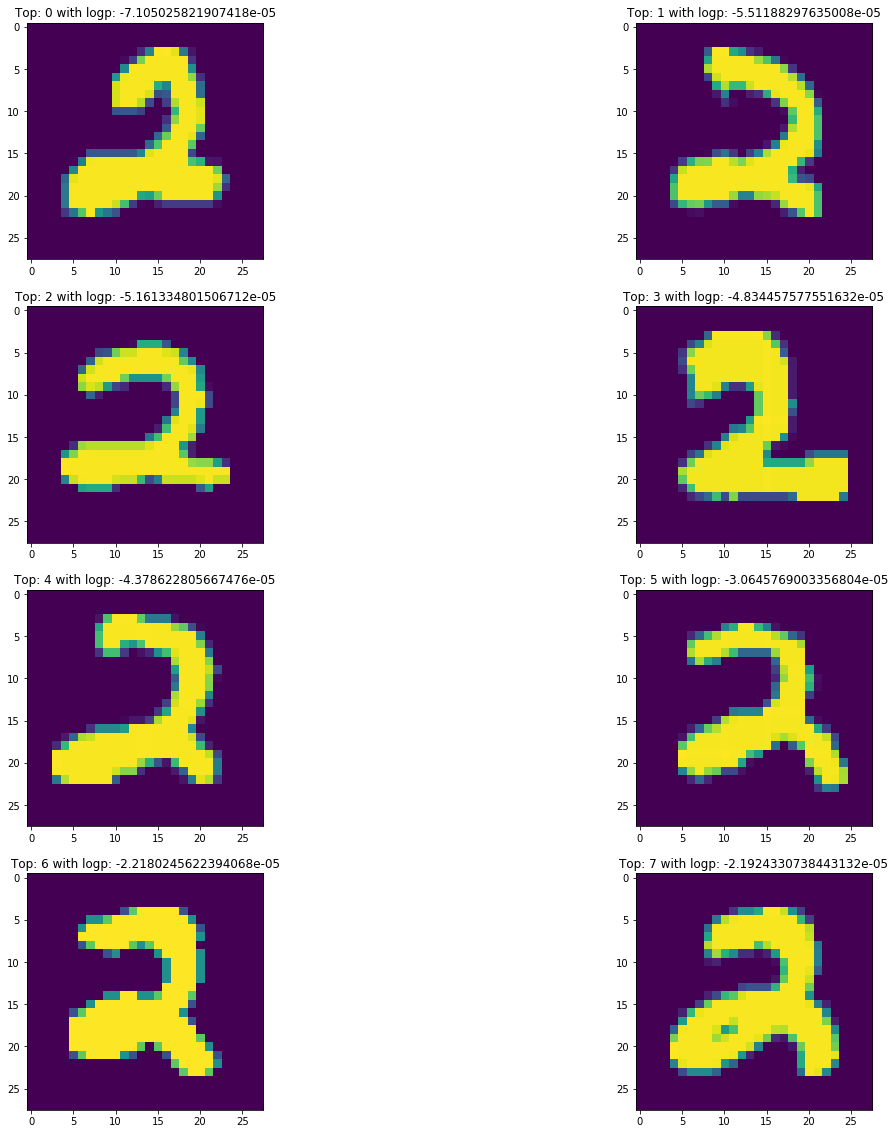

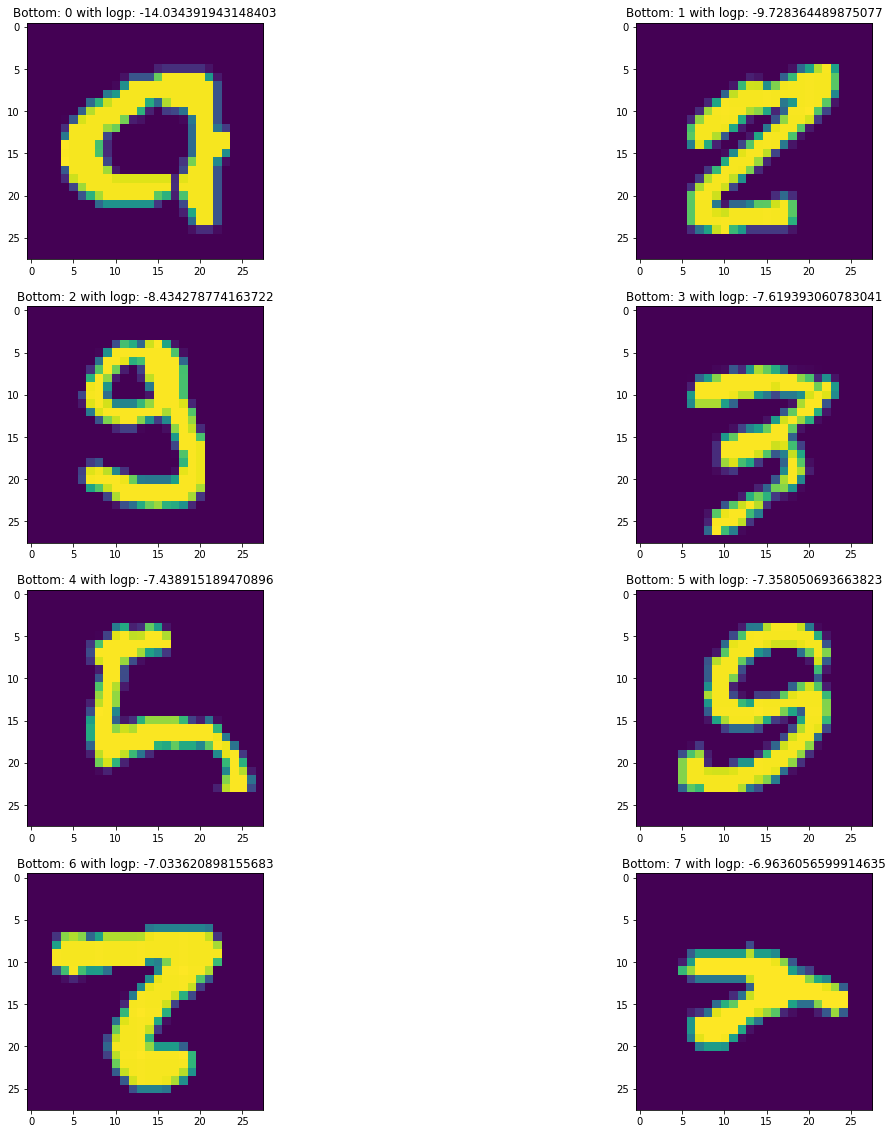

In [17]:
# Given a dataset of inputs x and targets t, and weights w, bias b
# returns the top eight and bottom eight logp scores and image indices in lists of tuples
def find_topbottoms_logp(xs, ts, w, b):
    # N is number of datapoints, scores_idx is the lists of tuples (logp, image_idx)
    N = xs.shape[0]
    scores_idx = []
    
    # Loop over all data points
    for i in range(N):
        # Get current input x and target t
        x, t = xs[i:i+1, :], [ts[i]]
        # Compute logp for current image
        logp, _, _ = logreg_gradient(x, t, w, b)
        
        # store logp and index in list of tuples
        scores_idx.append((float(logp), i))
        
    # Once entire dataset has been scored, sort the list of tuples by logp scores (ascending order)
    sorted_scores_idx = sorted(scores_idx, key=lambda tup: tup[0])
    
    # The top eight classified images will be the last eight images in the sorted list of tuples
    # The first eight images in the list are the bottom eight classified images
    top_eight = sorted_scores_idx[-8:]
    bottom_eight = sorted_scores_idx[:8]
    
    return top_eight, bottom_eight
    
# Function which, given a dataset of inputs, indices and logps, will 
# plot the images in a grid with corresponding logp scores
def plot_idx(xs, idx, logps, label='Top'):
    
    # Create subplot and set height and width
    fig, axs = plt.subplots(4, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    
    # Loop over all subplot axes
    for i, ax in enumerate(axs.flat):
        # Get current image index, image data and logp score
        curr_index = idx[i]
        logp = logps[i]
        curr_x = xs[curr_index, :]
        
        # Reshape image into correct size (assuming square image) and plot
        x_img = np.reshape(curr_x, (int(np.sqrt(curr_x.shape[0])), int(np.sqrt(curr_x.shape[0]))))
        ax.imshow(x_img)
        ax.set_title(f'{label}: {i} with logp: {logp}')

# Get tops and bottoms
tops, bottoms = find_topbottoms_logp(x_valid, t_valid, w, b)

# Get tops idx, logps, as well for the bottoms, in separate lists
tops_idx = [top[1] for top in tops]
tops_logps = [top[0] for top in tops]
bottoms_idx = [bottom[1] for bottom in bottoms]
bottoms_logps = [bottom[0] for bottom in bottoms]

# Now first plot the tops, then the bottoms
plot_idx(x_valid, tops_idx, tops_logps, label='Top')
plot_idx(x_valid, bottoms_idx, bottoms_logps, label='Bottom')

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

A digit is hard to classify if it is an outlier in the class where it may look different from the average image in that class, or if it is a handwritten digit that may look similar to another digit.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

$\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case. Because b is the bias on the last layer in the neural network. It is equivlent to the bias b in the logistic regression case.



$\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to earlier case

$\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j} =  w$

$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{V}} = \frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{log q_{j}}} \frac{\partial \mathcal{log q_{j}}}{\partial \mathbf{h}} \frac{\partial \mathcal{h}}{\partial \mathbf{XV+a}} \frac{\partial \mathcal{XV+a}}{\partial \mathbf{V}} =\mathbf{\delta}_j^h h_{j}(1-h_{j})x$





$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{a}} = \frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{log q_{j}}} \frac{\partial \mathcal{log q_{j}}}{\partial \mathbf{h}} \frac{\partial \mathcal{h}}{\partial \mathbf{XV+a}} \frac{\partial \mathcal{XV+a}}{\partial \mathbf{a}} =\mathbf{\delta}_j^h h_{j}(1-h_{j})$

$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{W}} =  \frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{log q_{j}}} \frac{\partial \mathcal{log q_{j}}}{\partial \mathbf{W}} = \mathbf{\delta}_{j}^q h$

$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{b}} =  \frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{logq_j}} \frac{\partial \mathcal{logq_j}}{\partial \mathbf{b}}= \mathbf{\delta}_{j}^q $

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

$ \textbf {log (posterior)} $


$ \propto \text{log (likehood * prior)}\\
\propto \text{log (likehood * p(v)*p(w))}\\
\propto \text{log (likehood) + log p(v) + log p(w))}$

$\text {we assume the mean of v and w is zero}$

$ \propto \text{log (likelihood)} + \log_e e^{\frac{-1}{2}(v-\mu_v)^{T} \Sigma^{-1}(v-\mu_v)}  + \log_e e^{\frac{-1}{2}(w-\mu_w)^{T} \Sigma^{-1}(w-\mu_w)} $

$ \propto \text{log (likelihood)} + \log_e e^{\frac{-1}{2}v^{T} \Sigma^{-1} v}  + \log_e e^{\frac{-1}{2}w^{T} \Sigma^{-1}w} $

$\frac{\partial }{\partial \mathbf{w}} \text{log(posterior)} =\frac{\partial }{\partial \mathbf{w}} \text{log(likelihood)} - \frac{1}{2} w^{T}\Sigma_w^{-1} $

$\frac{\partial }{\partial \mathbf{v}} \text{log(posterior)} =\frac{\partial }{\partial \mathbf{v}} \text{log(likelihood)} - \frac{1}{2} v^{T}\Sigma_v^{-1} $

$ w = w + \frac{\partial }{\partial \mathbf{w}}\text{log(posterior)}$

$v = v+ \frac{ \partial }{\partial \mathbf{v}} \text{log(posterior)}$

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

logp_train.mean -2.30283578495
logp_train.mean -2.30366168742
logp_train.mean -2.30535572613
logp_train.mean -2.30805310867
logp_train.mean -2.31211507509
logp_train.mean -2.31783024342
logp_train.mean -2.32572774978
logp_train.mean -2.33618173547
logp_train.mean -2.34913541494
logp_train.mean -2.36517008517
[-2.3028357849542846, -2.3036616874221179, -2.3053557261339717, -2.3080531086740406, -2.3121150750882862, -2.3178302434204197, -2.3257277497802544, -2.3361817354729384, -2.3491354149402484, -2.3651700851748085]


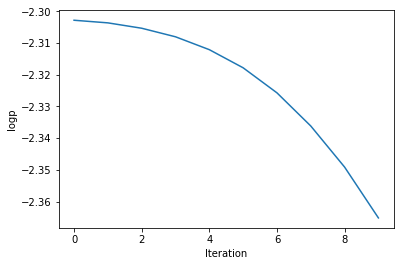

In [273]:
def sigmoid(x): 
    return 1. / (1. + np.exp(-x))

def sigmoid_gradient(x): 
    return sigmoid(x) * (1. - sigmoid(x))

def compute_gradient_NN (x,t,v,a,w,b ): # forward_and_backward
#     print ("x.shape:",x.shape)
    linear = x.dot(v) + a
    h = sigmoid(linear)
    logq = h.dot(w) + b 
    Z = np.sum(np.exp(logq))
    logZ = np.max(logq) + np.log(np.sum(np.exp(logq - np.max(logq))))
    logp = logq - logZ
    
    ######## above: forwardpass ########### bellow: backwardpass ###############
    dL_dq_t = 1. - (np.exp(logq)/Z)
    dL_dq_i = - (np.exp(logq)/Z)
    mask = np.array([False if i != t[0] else True for i in range(10)]) #???? what is mask
    dL_dq = np.where(mask, dL_dq_t, dL_dq_i)    

    dL_dh = dL_dq.dot(w.T)
    dL_db = dL_dq
    dL_dw = dL_dq.T.dot(h).T
    
    # dh_da is derivative of sigmoid (don't use .dot because we want element wise operation)
    dh_da = h*(1-h)
    # first compute dL_da because dL_dv = dL_da * x^T
    dL_da = dL_dq.dot(w.T)*dh_da
    dL_dv = dL_da.T.dot(x).T

    return logp, dL_dw, dL_db, dL_dv, dL_da


def sgd_iter_NN (x,t,w,b,v,a,k,lr):
    
    n = x.shape[0]  # n = number of data points
    
    shuffler = np.random.permutation(n)
    x = x[shuffler]
    t = t[shuffler]
   
    
    logp_train = np.zeros((n, k))  # nb datapoints *10
    for i in range(0,n):   
        target = t[i]
        t_asList= [target]
        
        x_train = np.reshape(x[i].T, (1, 784)) 

        logp, dL_dw, dL_db, dL_dv, dL_da = compute_gradient_NN (x_train,t_asList,v,a,w,b )
        logp_train[i,:] = logp

        w = w + lr * dL_dw
        a = a + lr * dL_da
        v = v + lr * dL_dv
        b = b + lr * dL_db
  

    logp_train = np.mean(logp_train) 

    return logp_train, w,b,v,a

def train(x, t, w_initial,b_initial,v_initial,a_initial,k,lr, epoch):
    logp_train_list =[]
    w = w_initial.copy()
    b = b_initial.copy()
    v = v_initial.copy()
    a = a_initial.copy()
    for i in range(0, epoch):
        logp_train, w,b,v,a = sgd_iter_NN (x,t, w,b,v,a,k,lr )
        logp_train_list.append (logp_train)
    return logp_train_list, w,b,v,a

def plot_logp(logp_train):
    x = [i for i in range(len(logp_train))]
    plt.plot(x, logp_train)
    plt.xlabel('Iteration')
    plt.ylabel('logp')

lr = 1e-2                   #1e-2, 1e-3 and 1e-4 #learning rate
L = 20                      # nb of hidden nodes in L
epoch =10
k = 10                      # k classes
np.random.seed(123)
w_initial = np.random.normal(size=(L,k), scale=0.001)
b_initial = np.zeros((1,k))
v_initial = np.random.normal(size=(28*28,L), scale=0.001)
a_initial = np.zeros((1,L))

slice_data = 5

logp_train_list, w,b,v,a = train(x_train[0:slice_data,:], t_train[0:slice_data], w_initial,b_initial,v_initial,a_initial,k,lr, epoch)

plot_logp(logp_train_list)


In [ ]:
# Hidden tests for efficiency

In [ ]:
# Write training code here:
# Plot the conditional loglikelihoods(logp) for the train and validation dataset after every iteration.
# Plot the weights of the first layer.



# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# plot the train and validation logp for all three learning rates in one figure

# YOUR CODE HERE
raise NotImplementedError()
    

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

YOUR ANSWER HERE

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

In [ ]:
# Plot the weights of the first layer for the best model 

# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

$ \frac{ \partial }{\partial \mathbf{a}} \text{tanh(a)} \\
= \frac{ \partial }{\partial \mathbf{a}} \frac{e^{x} -e^{-x}}{e^{x} +e^{-x}}\\
= \frac{4e^{2x} }{(e^{2x} +1)^2} 
$




$
\frac{ \partial }{\partial \mathbf{a}} \text{relu(a)}  \\
=\frac{ \partial }{\partial \mathbf{a}} \text{max(0,a)} \\
= \text{0 when a <= 0, = 1 when a>0}
$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

1) activation functions must be nonlinear. If they are linear, then we are not able to approximate complex functions. We want to combine linear mapping (for example h =Wx+b) with nonlinear mapping  (for example: sigmoid of (h))

2) activation function must have nice shape for derivative. Because we want to compute gradient. We want to use gradient to know how to optimize weights. If the derivative of activation function is a constant, no matter how its argument changes, then this is not a good to be choosen as an activation function. 


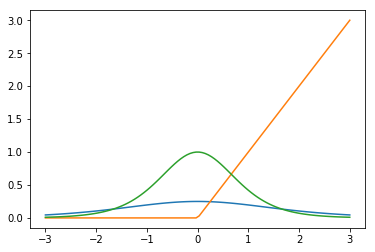

In [312]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.
import math
import matplotlib.pyplot as plt




def sigmoid_derivative (x):

    y = []
    for i in range (len(x)):
        y.append( float (math.exp(x[i]))/ (( float( math.exp(x[i]))+1)**2) )
    plt.plot(x, y)
    return
    
def relu_derivative (x):

    y = []
    for i in range (len(x)):
        y.append( max([0, x[i]]) )
    plt.plot(x, y)
    return
    
def tanh_derivative (x):
    
    y = []
    for i in range (len(x)):
        nominator = 4*math.exp(2*x[i])
        denominator = (math.exp(2*x[i])+1)**2
        y.append(nominator/denominator)
    plt.plot(x, y)
    return
    
x =  np.linspace(-3.0, 3.0, num=100)
sigmoid_derivative (x)
relu_derivative (x)
tanh_derivative (x)

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.



We think it depends on the problem. In most of cases, the Relu function is the best. Its derivative is influenced by x, when x goes to infinity. however the derivative of sigmoid and tanh is 0, when x goes to positive or negative infinity. For classification, it is fine to use sigmoid. Because it maps input to the range between 0 to 1. We need our probability to be between 0 to 1.  

In [313]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

AttributeError: 'numpy.ndarray' object has no attribute 'time'